# Merging Data to Understand the Relationship between Drug Legalization and Violent Crime



In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. In this exercise, we will explore this argument and explore the relationship between drug legalization and violent crime.

**To be clear,** drug legalization is a complex issue! This exercise is meant to help you think through how to address data science questions programmatically.

## Pre-Legalization Analysis

**(1)** We will begin by examining [county-level data on arrests from California in 2009](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca), which is derived from data provided by the Office of the California State Attorney General [here](https://openjustice.doj.ca.gov/data). Download and import the file `ca_arrests_2009.csv` from the first link above (the second one is just to show you where it came from). 

**(2)** Use your data exploration skills to get a feel for this data. If you need to, you can find the [original codebook here](https://data-openjustice.doj.ca.gov/sites/default/files/dataset/2019-07/Arrests%20Context_062119.pdf) (This data are similar, but have been collapsed to one observation per county.)

**(3)** Figuring out what county has the most violent arrests isn't very meaningful if we don't normalize for size. A county with 10 people and 10 arrests for violent crimes is obviously worse than a county with 1,000,000 people an 11 arrests for violent crime. 

To address this, also import `nhgis_county_populations.csv` from [the directory we're working from](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca).

**(4)** Use your data exploration skills to get used to these data and figure out how they relates to your 2009 arrest data. Determine the meaning of the various columns and check the data for completeness

**(5)** Once you feel like you have a good sense of the relation between our arrest and population data, merge the two datasets. 

## Checking Your Merges

**(6)** When you merge data, you have to make some assumptions about the nature of the data you're working with. For example, you have to assume it's OK to connect variables that share the same value of your merging variables. Similarly, you have to make assumptions about whether your merge a one-to-one merge (meaning there is only one observation of the variable you're merging on in both datasets), a one-to-many merge (meaning there is only one observation of the variable you're merging on in the first dataset, but multiple observations in the second). So before running a merge, answer the following questions:

1. What variable do you think will be consistent across these two datasets you can use for merging?
2. Do you think there will be exactly 1 observation for each value in your *arrest* data?
3. Do you think there will be exactly 1 observation for each value in your *population* data?

Being correct in your assumptions about these things is *very* important. If you think there's only one observation per value of your merging variable in each dataset, but there are in fact 2, you'll end up with two observations for each value after the merge. If that were two happen, the structure of your data would be damaged and it would indicate that you didn't understand something about your data. 

Because of the importance of this, `pandas` provides a utility for *testing* these assumptions when you do a merge: the `validate` keyword! Validate will accept `"1:1"`, `"1:m"`, `"m:1"`, and `"m:m"` where the 'm' stands for "many". It will then check to make sure your merge matches the type of merge you think it is. I *highly* recommend always using this option.

Repeat the merge you conducted above, but this time use the `validate` keyword to make sure your assumptions about the data were correct. 

**(7)** Checking whether you are doing a one-to-one, many-to-one, one-to-many, or many-to-many merge is only the first type of diagnostic test you should run on *every* merge you conduct. The second test is to see if you data merged successfully!

To help with this, the `merge` function in pandas offers a keyword option called `indicator`. If you set `indicator` to `True`, then pandas will add a column to the result of your merge called `_merge`. This variable will tell you, for each observation in your merged data, whether:  (a) that observation came from a successful merge of both datasets, (b) if that observation was in the left dataset (the first one you passed) but not the right dataset, or (c) if that observation was in the right dataset but not the left). This allows you to quickly identify failed merges!

For example, suppose you had the following data:

In [2]:
import pandas as pd
df1 = pd.DataFrame({'key':['key1', 'key2'], 'df1_var':[1, 2]})
df1

,key,df1_var
0,key1,1
1,key2,2


In [3]:
df2 = pd.DataFrame({'key':['key1', 'Key2'], 'df2_var':['a', 'b']})
df2

,key,df2_var
0,key1,a
1,Key2,b


Now suppose you *expected* that all observations should merge when you merge these datasets (because you hadn't noticed the typo in `df2` where `key2` has a capital `Key2`. If you just run a merge, it works without any problems:

In [4]:
new_data = pd.merge(df1, df2, on='key', how='outer')

And so you might carry on in life unaware your data is now corrupted: instead of two merged rows, you now have 3, only 1 of which merged correctly!

In [5]:
new_data

,key,df1_var,df2_var
0,key1,1.0,a
1,key2,2.0,NaN
2,Key2,NaN,b


When what you really wanted was: 

In [6]:
df2_correct = df2.copy()
df2_correct.loc[df2.key == "Key2", "key"] = 'key2'
pd.merge(df1, df2_correct, on='key', how='outer')

,key,df1_var,df2_var
0,key1,1,a
1,key2,2,b


(in a small dataset, you'd quickly see you have 1 row instead of 2, but if you have millions of rows, a couple missing won't be evident). 

But now suppose we use the `indicator` function:

In [7]:
new_data = pd.merge(df1, df2, on='key', how='outer', indicator=True)
new_data._merge.value_counts()

both          1
right_only    1
left_only     1
Name: _merge, dtype: int64

We could immediately see that only one observation merged correct, and that one row from each dataset failed to merge!

Moreover, we can look at the failed merges:

In [8]:
new_data[new_data._merge != "both"]

,key,df1_var,df2_var,_merge
1,key2,2.0,NaN,left_only
2,Key2,NaN,b,right_only


Allowing us to easily diagnose the problem. 

**Note:** The `pandas` merge function allows users to decide whether to keep only observations that merge (`how='inner'`), all the observations from the first dataset pasted to merge (`how='left'`), all the observations from the second dataset passed to merge (`how='right'`), or all observations (`how='outer'`):

But one danger to using the more restrictive options (like the default, `how='inner'`) is that the merge throws away all the observations that fail to merge, and while this may be the *eventual* goal of your analysis, it means that you don't get to see all the observations that failed to merge that maybe you thought *would* merge. In other words, it throws away the errors so you can't look at them!  

So to use `indicator` effectively, you have to:

- Not use `how="inner"`, and
- Check the values of `_merge` after your merge. 

**(8)** Now repeat your previous merge using *both* the `validate` keyword *and* the `indicator` keyword with `how='outer'`. 

**(9)** You *should* be able to get to the point that all counties in our arrest data merge with population data. Can you figure out why that did not happen? Can you fix the data so that they all merge to population data?

## Comparing Arrest Rates

**(10)** Now that we have arrest counts and population data, we can calculate arrest *rates*. For each county, create a new variable called `violent_arrest_rate_2009` that is the number of violent arrests for 2009 divided by the population of the county from 2005-2009, and an analogous variable for drug offenses (`F_DRUGOFF`). 

**(11)** Make a scatter plot that shows the relationship between each county's violent arrest rate and it's drug arrest rate. While we haven't discussed scatter plots yet, you can use the code below to help you get started:



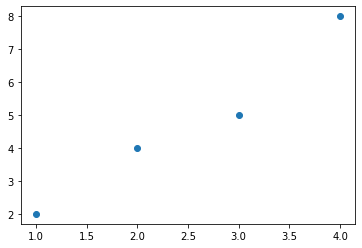

In [2]:
import matplotlib.pyplot as plt
x = [1,2,3,4]
y = [2,4,5,8]
plt.scatter(x,y)

## Comparing with 2018 Arrests

Showing that drug arrests and violent crime arrests tend to be positively correlated does not tell us much about whether they are *causally* relation. It *could* be the case that people dealing drugs *causes* more violent crime, but it could also be that certain communities, for some other reason, tend to have *both* more drug sales *and* more violent crime. 

So to test for this, we went to see if the same communities that had violent crime in 2009 *also* have violent crime in 2019 (after marijuana legalization). If these communities have just as much crime in 2018, that would suggest that violent crime is being driven by a third factor, and not drug sales of marijuana. 

**(12)** Just as we created violent arrest rates and drug arrest rates for 2009, now we want to do it for 2018. Using the data on 2018 arrests (also in the [same repository](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca) we used before) and the same dataset of population data (you'll use population from 2013-2017, as 2018 population data has yet to be released), create a dataset of arrest rates. 

As before, *be careful with your merges!!!*

**(13)** Now merge the two county-level datasets so you have one row for every county, and variables for violent arrest rates in 2018, violent arrest rates in 2009, felony drug arrest rates in 2018, and felony drug arrest rates in 2009. 

**(14)** Did drug arrests go down from 2009 to 2018? (they sure better! This is what's called a "sanity check" of your data and analysis. If you find drug arrests went *up*, you know something went wrong with your code or your understanding of the situations. 

**(15)** Now we want to look at whether violent crime decreased following drug legalization. Did the average violent arrest rate decrease? By how much? (Note: We're assuming that arrest rates are proportionate to crime rates. If policing increased so that there were more arrests per crime committed, that would impact our interpretation of these results. But this is just an exercise, so...)

**(16)** So we've determined that both drug arrests and violent crime arrests were decreasing over this period. But maybe *all* crime was just falling, and this isn't about drug legalization. 

This is the problem with a "pre-to-post" analysis: yes, our results are *consistent* with the idea that drug legalization reduced violent crime, but lots of things happened between 2009 and 2018, not just drug legalization, so we don't know that drug legalization *caused* the decline in violent crime. 

So let's do a kind of difference-in-difference analysis. We know that drug legalization should have had a bigger effect on counties that had higher drug arrest rates prior to drug legalization. After all, in a county that had no drug arrests, legalization wouldn't do anything, would it? 

So let's split our sample into two groups: high drug arrests in 2009, and low drug arrests in 2009 (split the sample at the average drug arrest rate in 2009). 

Now we can ask: did violent crime fall *more* from 2009 to 2018 in the counties that had lots of drug arrests in 2009 (where legalization likely had more of an effect) than in counties with fewer drug arrests in 2009 (where legalization likely mattered less)? Calculate this using what we call a difference-in-differences:

(the change in violent crime rate for counties with lots of drug arrests in 2009) - (the change in violent crime rate for counties with few drug arrests in 2009)

**(17)** Hmmm... we showed that there was a greater *absolute* decline in violent arrest rates in counties more impacted by drug legalization. But was there also a greater *proportionate* decline?

Calculate:

(the percentage change in violent crime rate for counties with lots of drug arrests in 2009) - (the percentage change in violent crime rate for counties with few drug arrests in 2009)

**(18)** What are your conclusions about the relationship between violent crime and drug legalization, give your analysis above?